# Generate ~300x300m grids on areas of interest

# Set Up

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import sys
import numpy as np
import pandas as pd
import pandas_gbq as gbq
from tqdm import tqdm

# Geospatial processing packages
import geopandas as gpd
from geowrangler import grids
from geowrangler.validation import GeometryValidation
from shapely import wkt
from shapely.geometry.polygon import orient

/home/avell/miniconda3/envs/geo-re-demo/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [8]:
# Util imports
sys.path.append("../../")  # include parent directory
from src.settings import ADM_BQ_ID, GRIDS_300m_BQ_ID, GCP_PROJ_ID

## Load Data

### Admin bounds

In [13]:
# query for subset of adm_zone
adm_zone_query = f"""
  SELECT
    *
  FROM
  `{ADM_BQ_ID}`
  WHERE 
    ADM1_EN = 'National Capital Region'
  """
# convert from adm_zone table to gdf
adm_df = gbq.read_gbq(adm_zone_query, GCP_PROJ_ID, dialect="standard")
adm_gdf = gpd.GeoDataFrame(
    adm_df, geometry=adm_df.geometry.apply(wkt.loads), crs="EPSG:4326"
)
adm_gdf.head(2)

Downloading: 100%|██████████| 30/30 [00:02<00:00, 14.60rows/s]


,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_EN,ADM3_PCODE,geometry
0,PH130000000,National Capital Region,PH133900000,"NCR, City of Manila, First District",Tondo I / II,PH133901000,"MULTIPOLYGON (((120.97991 14.63553, 120.97990 ..."
1,PH130000000,National Capital Region,PH133900000,"NCR, City of Manila, First District",San Miguel,PH133907000,"POLYGON ((120.98789 14.59449, 120.98779 14.594..."


# Generate grids using geowrangler

## Create grids by province

In [11]:
%%time
# set grid parameters - See grid resolution here https://learn.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system
bing_tile_grid_generator = grids.BingTileGridGenerator(17)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 14.5 µs


In [14]:
table_schema = [
    {"name": "quadkey", "type": "STRING"},
    {"name": "ADM1_EN", "type": "STRING"},
    {"name": "ADM1_PCODE", "type": "STRING"},
    {"name": "ADM2_EN", "type": "STRING"},
    {"name": "ADM2_PCODE", "type": "STRING"},
    {"name": "ADM3_EN", "type": "STRING"},
    {"name": "ADM3_PCODE", "type": "STRING"},
    {"name": "ADM4_EN", "type": "STRING"},
    {"name": "ADM4_PCODE", "type": "STRING"},
    {"name": "geometry", "type": "GEOGRAPHY"},
]

grids_wadm = []

In [15]:
%%time
for adm2 in tqdm(adm_gdf.ADM2_PCODE.unique()):
    _adm_gdf = adm_gdf[adm_gdf.ADM2_PCODE == adm2]
    _grid_gdf = bing_tile_grid_generator.generate_grid(_adm_gdf)
    _grids_wadm = _grid_gdf.sjoin(_adm_gdf, predicate="intersects")
    _grids_wadm.drop(columns=["index_right"], inplace=True)

    # export results to BQ
    gbq.to_gbq(
        _grids_wadm,
        GRIDS_300m_BQ_ID,
        GCP_PROJ_ID,
        if_exists="append",
        table_schema=table_schema,
        progress_bar=True,
        chunksize=10000,  # chunk the upload to stay within BQ limits
        api_method="load_csv",  # chunksize only works if load_csv (default is load_parquet)
    )
    grids_wadm.append(_grids_wadm)

# Concat tables for inspection
grids_wadm = pd.concat(grids_wadm)

1it [00:04,  4.01s/it]00:00<?, ?it/s]
1it [00:06,  6.45s/it]00:06<00:19,  6.39s/it]
1it [00:05,  5.42s/it]00:14<00:14,  7.21s/it]
1it [00:04,  4.30s/it]00:21<00:07,  7.14s/it]
100%|██████████| 4/4 [00:27<00:00,  6.88s/it]

CPU times: user 3.77 s, sys: 39.9 ms, total: 3.81 s
Wall time: 27.5 s


## Grid QA

In [16]:
grids_wadm.shape

(8337, 8)

In [17]:
grids_wadm.head(2)

,quadkey,geometry,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,ADM3_EN,ADM3_PCODE
0,13230303311111110,"POLYGON ((120.93201 14.60219, 120.93201 14.604...",PH130000000,National Capital Region,PH133900000,"NCR, City of Manila, First District",Tondo I / II,PH133901000
1,13230303311111111,"POLYGON ((120.93475 14.60219, 120.93475 14.604...",PH130000000,National Capital Region,PH133900000,"NCR, City of Manila, First District",Tondo I / II,PH133901000


### Plot grids to check

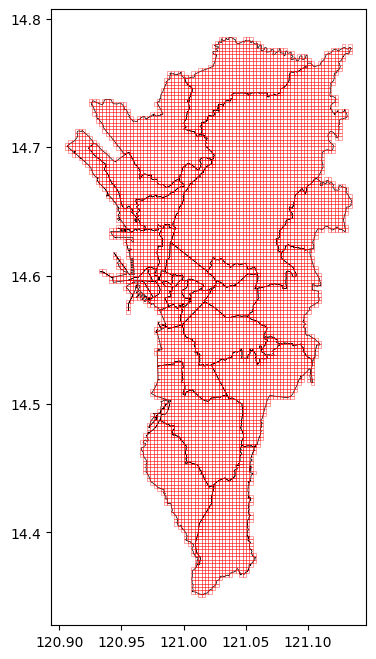

In [18]:
# Plot for sense checking
ax = adm_gdf.plot(
    facecolor="none", edgecolor="black", legend=True, figsize=[8, 8], linewidth=0.5
)
ax = grids_wadm.plot(ax=ax, facecolor="none", edgecolor="red", alpha=0.5, linewidth=0.5)